In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

print('start')
rankings = pd.read_csv('fifa_ranking.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])
# print(rankings['rank_date'].head())
print(rankings.head())
print('\n_______________\n')


matches = pd.read_csv('results.csv')
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])
print(matches.head())

world_cup = pd.read_csv('World Cup 2018 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')
print('stop')

start
   rank country_full country_abrv  cur_year_avg_weighted  rank_date  \
0     1      Germany          GER                    0.0 1993-08-08   
1     2        Italy          ITA                    0.0 1993-08-08   
2     3  Switzerland          SUI                    0.0 1993-08-08   
3     4       Sweden          SWE                    0.0 1993-08-08   
4     5    Argentina          ARG                    0.0 1993-08-08   

   two_year_ago_weighted  three_year_ago_weighted  weighted_points  
0                    0.0                      0.0              0.0  
1                    0.0                      0.0              0.0  
2                    0.0                      0.0              0.0  
3                    0.0                      0.0              0.0  
4                    0.0                      0.0              0.0  

_______________

        date home_team away_team  home_score  away_score tournament     city  \
0 1872-11-30  Scotland   England           0           

In [2]:
# I want to have the ranks for every day 
print('start')
rankings2=rankings.copy(deep=False)
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# print(rankings.head())
# rankings1=rankings2.set_index(['rank_date'])\
#             .groupby(['country_full'], group_keys=False)\
#     .resample('D').first()\
#     .fillna(method='ffill')\
#     .reset_index()
# print(rankings.head())

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
print(matches.head())
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))
print('\n____________________\n')
print(matches.head())
matches_new=matches.copy()

start
        date home_team     away_team  home_score  away_score  \
0 1993-08-08   Bolivia       Uruguay           3           1   
1 1993-08-08    Brazil        Mexico           1           1   
2 1993-08-08   Ecuador     Venezuela           5           0   
3 1993-08-08    Guinea  Sierra Leone           1           0   
4 1993-08-08  Paraguay     Argentina           1           3   

                     tournament      city   country  neutral  rank_date  rank  \
0  FIFA World Cup qualification    La Paz   Bolivia    False 1993-08-08  59.0   
1                      Friendly    Maceió    Brazil    False 1993-08-08   8.0   
2  FIFA World Cup qualification     Quito   Ecuador    False 1993-08-08  35.0   
3                      Friendly   Conakry    Guinea    False 1993-08-08  65.0   
4  FIFA World Cup qualification  Asunción  Paraguay    False 1993-08-08  67.0   

  country_full country_abrv  cur_year_avg_weighted  two_year_ago_weighted  \
0      Bolivia          BOL                  

In [3]:
# feature generation
print('start')
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'

# I tried earlier rest days but it did not turn to be useful
max_rest = 30
matches['rest_days'] = matches.groupby('home_team').diff()['date'].dt.days.clip(0,max_rest).fillna(max_rest)

# I tried earlier the team as well but that did not make a difference either
matches['wc_participant'] = matches['home_team'] * matches['home_team'].isin(world_cup.index.tolist())
matches['wc_participant'] = matches['wc_participant'].replace({'':'Other'})
matches = matches.join(pd.get_dummies(matches['wc_participant']))

start


In [4]:
# import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
from time import time
from sklearn.metrics import f1_score, accuracy_score


def distribution(data, features,transformed = False):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Create figure
    fig = plt.figure(figsize=(15,15));
    fig.subplots_adjust(hspace=0.5, wspace=0.2)
    # Skewed feature plotting
    for i, feature in enumerate(features):
        ax = fig.add_subplot(3, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        #ax.set_ylim((0, 2000))
        #ax.set_yticks([0, 500, 1000, 1500, 2000])
        #ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot aesthetics
    #if transformed:
     #   fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
      #      fontsize = 16, y = 1.03)
    #else:
     #   fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
      #      fontsize = 16, y = 1.03)
    
    #fig.tight_layout()
    plt.show()


0    [12.1799075267, 4.99853310007, 16.2818329729, ...
1                                             0.552529
dtype: object

___________



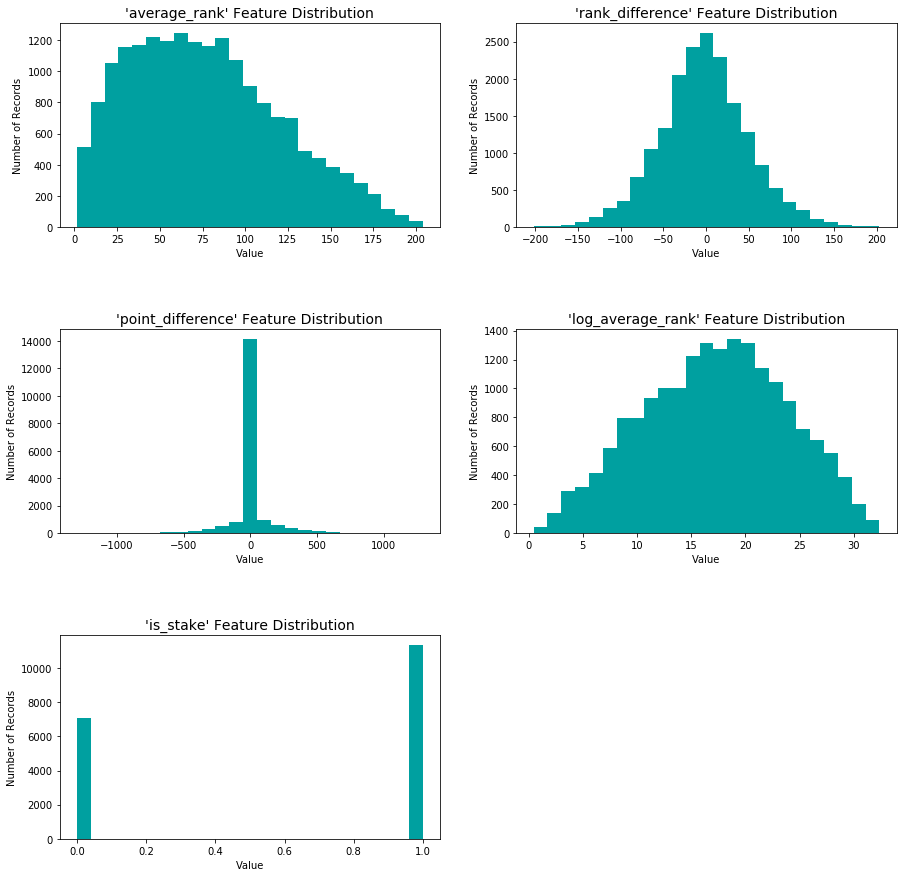

In [5]:
# import visuals as vs
# vs.distribution(matches_new)
# print(matches_new.head())
from scipy.stats import boxcox
data_g=pd.Series(boxcox(matches['average_rank']))
print(data_g)
# aa=pd.DataFrame(data_g[0])
# print(aa.head())
matches['log_average_rank']=data_g[0]
features=['average_rank', 'rank_difference', 'point_difference','log_average_rank','is_stake'];
print('\n___________\n')
distribution(matches,features)

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

def draw_scatterplot(x_data, x_label, y_data, y_label,col):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30,c=col)
    fig.show()
    
def draw_scatteringPlot(x_data, x_label, y_data, y_label,col):
    fig = plt.figure(figsize=(8,8))
    plt.scatter(x_data, y_data, s=30, c=col)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

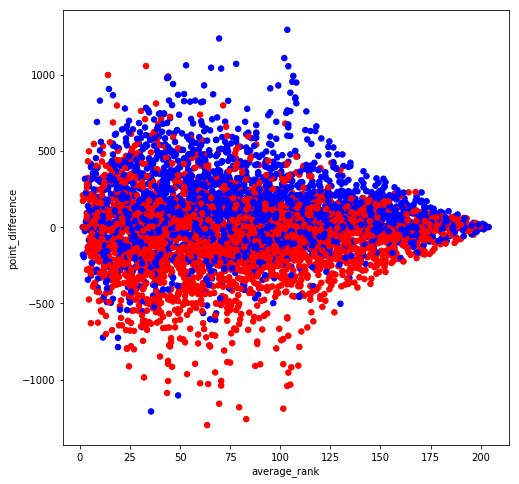

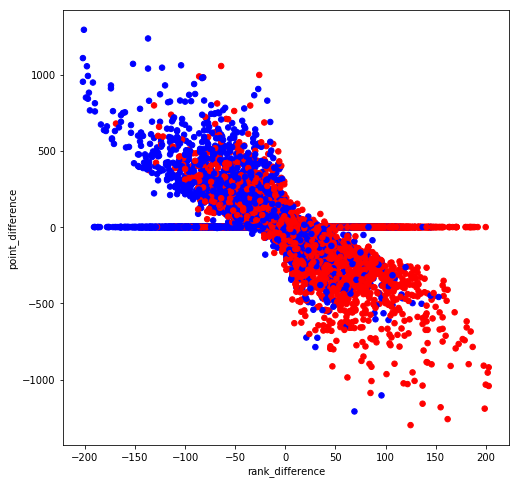

In [17]:
col=np.where(matches['is_won'],'b','r')
draw_scatteringPlot(matches['average_rank'], 'average_rank',matches['point_difference'],'point_difference', col)
draw_scatteringPlot(matches['rank_difference'], 'rank_difference',matches['point_difference'],'point_difference',col)


(18479, 67)
(11376, 67)


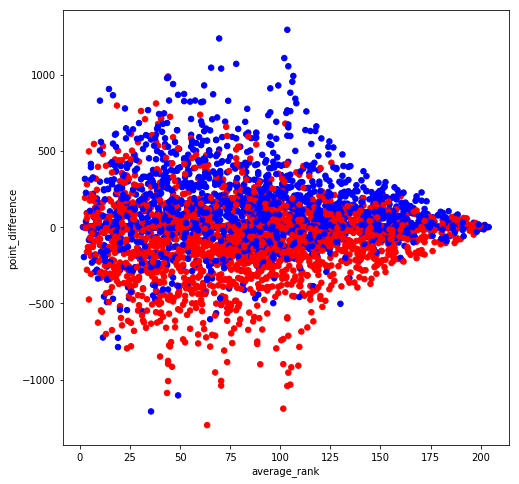

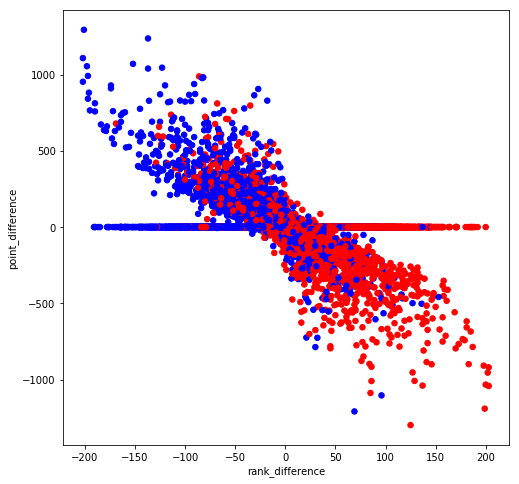

In [30]:
matches_atStake=matches.loc[np.where(matches['is_stake'])]
print(matches.shape)
print(matches_atStake.shape)
col=np.where(matches_atStake['is_won'],'b','r')
draw_scatteringPlot(matches_atStake['average_rank'], 'average_rank',matches_atStake['point_difference'],'point_difference', col)
draw_scatteringPlot(matches_atStake['rank_difference'], 'rank_difference',matches_atStake['point_difference'],'point_difference',col)